https://notebook.community/google/eng-edu/ml/pc/exercises/image_classification_part3

In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O ./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-06-17 06:09:35--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.128, 74.125.202.128, 74.125.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

./inception_v3_weig 100%[===================>]  83.84M   210MB/s    in 0.4s    

2023-06-17 06:09:35 (210 MB/s) - ‘./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

#local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

In [4]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [5]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [6]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


In [7]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['acc'])

In [8]:
!wget --no-check-certificate \
   https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
   cats_and_dogs_filtered.zip

--2023-06-17 06:09:50--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.128, 74.125.202.128, 74.125.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   164MB/s    in 0.4s    

2023-06-17 06:09:50 (164 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [9]:
import os
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator

local_zip = 'cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

# Define our example directories and files
base_dir = 'cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
from tensorflow.keras.optimizers import SGD

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# As an optimizer, here we will use SGD
# with a very low learning rate (0.00001)
model.compile(loss='binary_crossentropy',
              optimizer=SGD(
                  learning_rate=0.00001,
                  momentum=0.9),
              metrics=['acc'])

In [11]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

<ipython-input-11-084fa1662df2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
100/100 - 31s - loss: 0.6929 - acc: 0.5260 - val_loss: 0.6667 - val_acc: 0.5950 - 31s/epoch - 306ms/step
Epoch 2/100
100/100 - 21s - loss: 0.6720 - acc: 0.5805 - val_loss: 0.6513 - val_acc: 0.6430 - 21s/epoch - 206ms/step
Epoch 3/100
100/100 - 20s - loss: 0.6569 - acc: 0.6235 - val_loss: 0.6363 - val_acc: 0.6790 - 20s/epoch - 199ms/step
Epoch 4/100
100/100 - 21s - loss: 0.6491 - acc: 0.6385 - val_loss: 0.6220 - val_acc: 0.7100 - 21s/epoch - 209ms/step
Epoch 5/100
100/100 - 21s - loss: 0.6362 - acc: 0.6770 - val_loss: 0.6069 - val_acc: 0.7370 - 21s/epoch - 206ms/step
Epoch 6/100
100/100 - 21s - loss: 0.6268 - acc: 0.6805 - val_loss: 0.5925 - val_acc: 0.7610 - 21s/epoch - 210ms/step
Epoch 7/100
100/100 - 21s - loss: 0.6200 - acc: 0.6970 - val_loss: 0.5797 - val_acc: 0.7770 - 21s/epoch - 209ms/step
Epoch 8/100
100/100 - 22s - loss: 0.5996 - acc: 0.7325 - val_loss: 0.5668 - val_acc: 0.7910 - 22s/epoch - 217ms/step
Epoch 9/100
100/100 - 20s - loss: 0.5929 - acc: 0.7495 - val_los

Text(0.5, 1.0, 'Training and validation loss')

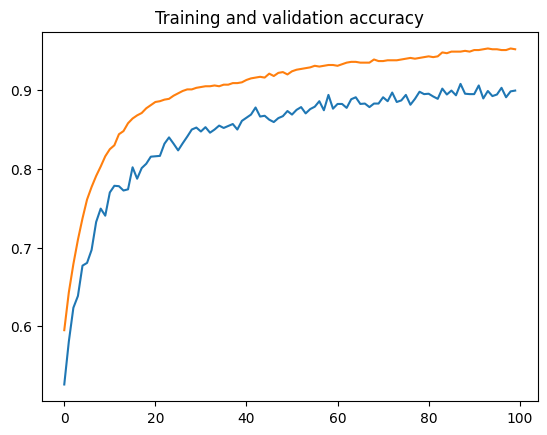

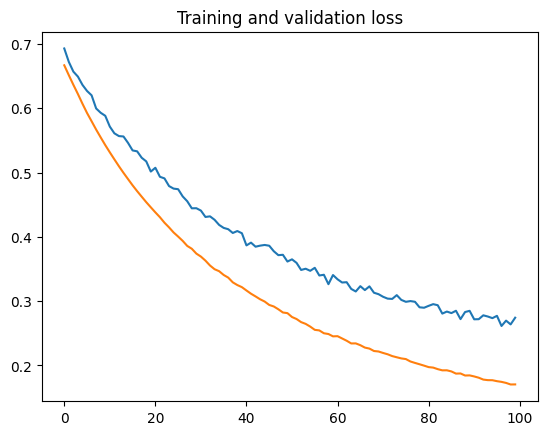

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [13]:
import numpy as np
from google.colab import files
#from keras.preprocessing import image
import keras.utils as image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  print(classes)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving cat-300572_1280.jpeg to cat-300572_1280 (1).jpeg
Saving cat-1045782_1280.jpeg to cat-1045782_1280 (1).jpeg
Saving cat-1192026_1280.jpeg to cat-1192026_1280 (2).jpeg
Saving cat-1455468_1280.jpeg to cat-1455468_1280 (2).jpeg
Saving cat-2083492_1280.jpeg to cat-2083492_1280 (2).jpeg
Saving cat-3523992_1280.jpeg to cat-3523992_1280 (1).jpeg
Saving Unknown.jpeg to Unknown (4).jpeg
1/1 [==============================] - 2s 2s/step
[[3.2313927e-10]]
[3.2313927e-10]
cat-300572_1280.jpeg is a cat
1/1 [==============================] - 0s 26ms/step
[[5.6366032e-05]]
[5.6366032e-05]
cat-1045782_1280.jpeg is a cat
1/1 [==============================] - 0s 28ms/step
[[4.5167457e-18]]
[4.5167457e-18]
cat-1192026_1280.jpeg is a cat
1/1 [==============================] - 0s 25ms/step
[[7.0575385e-07]]
[7.0575385e-07]
cat-1455468_1280.jpeg is a cat
1/1 [==============================] - 0s 25ms/step
[[0.00033979]]
[0.00033979]
cat-2083492_1280.jpeg is a cat
1/1 [==============================] -

In [16]:
uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  print(classes)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving dog.2000.jpg to dog.2000.jpg
Saving dog.2001.jpg to dog.2001.jpg
Saving dog.2002.jpg to dog.2002.jpg
Saving dog.2003.jpg to dog.2003.jpg
Saving dog.2004.jpg to dog.2004.jpg
Saving dog.2005.jpg to dog.2005.jpg
1/1 [==============================] - 0s 26ms/step
[[0.99991906]]
[0.99991906]
dog.2000.jpg is a dog
1/1 [==============================] - 0s 28ms/step
[[1.686459e-18]]
[1.686459e-18]
dog.2001.jpg is a cat
1/1 [==============================] - 0s 27ms/step
[[0.98411]]
[0.98411]
dog.2002.jpg is a dog
1/1 [==============================] - 0s 27ms/step
[[0.99989843]]
[0.99989843]
dog.2003.jpg is a dog
1/1 [==============================] - 0s 29ms/step
[[0.95753306]]
[0.95753306]
dog.2004.jpg is a dog
1/1 [==============================] - 0s 27ms/step
[[3.5978845e-11]]
[3.5978845e-11]
dog.2005.jpg is a cat
